In [6]:
# set up imports
import pandas as pd, numpy as np, seaborn as sns
from tabulate import tabulate
import statsmodels
import arch
import matplotlib
matplotlib.use('qt5agg')

# configure plot style
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["figure.figsize"] = (7,2.75)
plt.rcParams['figure.constrained_layout.use'] = False
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 0.8
save_plot_to =  r'C:\\Users\joche\OneDrive\03 TUM - TUM-BWL\Semester 8\01 Bachelorarbeit\04 Results\Plots/'

In [3]:
# load data from excel file
mydateparser = lambda x: pd.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
btc = pd.read_excel('Data/BTC_closing.xlsx',squeeze=True, parse_dates=[0], index_col=0, date_parser=mydateparser)

# crop data: 2015-08-07 to 2020-06-26
start_date = '2015-08-07'
end_date = '2020-06-26'
btc = btc[start_date : end_date]

In [4]:
# Create returns and squared returns
btc_returns = btc.pct_change().mul(100)
btc_returns_squared = btc_returns.mul(btc_returns)

C:\Users\joche\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'btc_returns_squared')

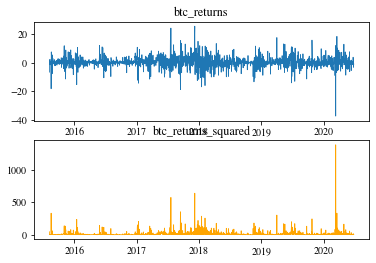

In [5]:
# Plot btc returns and btc squared returns
fig_1, axs = plt.subplots(2,1)
axs[0].plot(btc_returns[1:])
axs[0].set_title('btc_returns')
axs[1].plot(btc_returns_squared[1:], color='orange')
axs[1].set_title('btc_returns_squared')

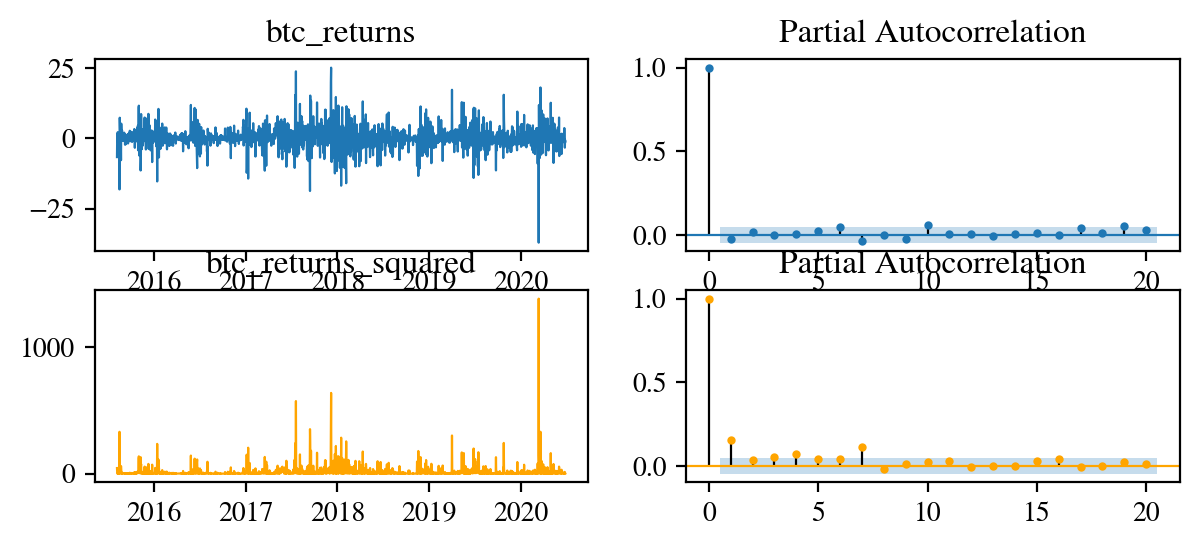

In [8]:
# plot pacf for returns and squared returns
from statsmodels.graphics.tsaplots import plot_pacf
fig_2, axs = plt.subplots(2,2)
axs[0][0].plot(btc_returns[1:])
axs[0][0].set_title('btc_returns')
axs[1][0].plot(btc_returns_squared[1:], color='orange')
axs[1][0].set_title('btc_returns_squared')
plot_pacf(btc_returns[1:], ax= axs[0][1], lags=20, markersize=2)
plot_pacf(btc_returns_squared[1:], ax= axs[1][1], lags=20, color='orange', markersize=2)

In [133]:
# Lagrange Multiplier Test

Date
2015-08-08   -6.645683
2015-08-09    1.563218
2015-08-10   -0.230119
2015-08-11    2.238439
2015-08-12   -1.483043
                ...   
2020-06-22    3.709197
2020-06-23   -0.197539
2020-06-24   -3.282047
2020-06-25   -0.523964
2020-06-26   -1.099753
Name: Close, Length: 1785, dtype: float64

In [9]:
# fit ARCH model to the returns
from arch import arch_model
model = arch_model(btc_returns[1:], p=1, q=1,
                   mean='constant', dist='t')
model_fitted = model.fit()
model_fitted.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 44198.22260228323
Iteration:      2,   Func. Count:     15,   Neg. LLF: 36941.07207901518
Iteration:      3,   Func. Count:     23,   Neg. LLF: 6736.462670305205
Iteration:      4,   Func. Count:     30,   Neg. LLF: 5889.498261281179
Iteration:      5,   Func. Count:     37,   Neg. LLF: 5806.557304488026
Iteration:      6,   Func. Count:     44,   Neg. LLF: 4554.806102274382
Iteration:      7,   Func. Count:     51,   Neg. LLF: 4534.626764767673
Iteration:      8,   Func. Count:     58,   Neg. LLF: 4750.169883901435
Iteration:      9,   Func. Count:     65,   Neg. LLF: 4530.869709219058
Iteration:     10,   Func. Count:     72,   Neg. LLF: 4525.5780617206965
Iteration:     11,   Func. Count:     78,   Neg. LLF: 4525.595475063112
Iteration:     12,   Func. Count:     85,   Neg. LLF: 4525.540665771288
Iteration:     13,   Func. Count:     92,   Neg. LLF: 4525.534400362229
Iteration:     14,   Func. Count:     98,   Neg. LLF: 4525.5342

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                        Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -4525.53
Distribution:      Standardized Student's t   AIC:                           9061.07
Method:                  Maximum Likelihood   BIC:                           9088.50
                                              No. Observations:                 1785
Date:                      Mon, Aug 31 2020   Df Residuals:                     1780
Time:                              10:36:38   Df Model:                            5
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1896  4.247e-02      4.464  8.044e-06 [  0.106,  0.273]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1330      0.104      1.278      0.201 [-7.098e-02,  0.337]
alpha[1]       0.1238  1.969e-02      6.288  3.211e-10  [8.522e-02,  0.162]
beta[1]        0.8762  2.816e-02     31.114 1.550e-212    [  0.821,  0.931]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.1844      0.167     19.119  1.761e-81 [  2.858,  3.511]
========================================================================

Covariance estimator: robust
"""

In [51]:
# save current model summary as LaTeX to .txt file
with open(save_plot_to+'ARCH_GARCH_logs_LaTeX.txt', 'a') as myfile:
    myfile.write(model_fitted.summary().as_latex()+'\n\n')

In [10]:
# Teile btc_returns in 80% train und 20% test
train_size = int(len(btc_returns[1:]) * 0.8)
btc_returns_train, btc_returns_test = btc_returns[:train_size], btc_returns[train_size:]
print('btc_returns_train:\t', len(btc_returns_train), '\nbtc_returns_test:\t', len(btc_returns_test),
      '\nSUM:\t\t\t', len(btc_returns_train) + len(btc_returns_test), '\nlen(btc_returns):\t', len(btc_returns))

btc_returns_train:	 1428 
btc_returns_test:	 358 
SUM:			 1786 
len(btc_returns):	 1786


In [58]:
btc_returns_train.index[1]

Date
2015-08-07          NaN
2015-08-08    -6.645683
2015-08-09     1.563218
2015-08-10    -0.230119
2015-08-11     2.238439
                ...    
2019-06-30    -9.550754
2019-07-01    -2.163507
2019-07-02     2.065079
2019-07-03    10.735275
2019-07-04    -6.235375
Name: Close, Length: 1428, dtype: float64

In [11]:
# fit GARCH(1,1), constant mean, t-dist to train, then predict 1 step for len(test)
from arch import arch_model
model = arch_model(btc_returns[1:], p=1, q=1, mean='constant', dist='t')
model_fitted = model.fit(first_obs=btc_returns_train.index[1], last_obs=btc_returns_train.index[-1])
model_result = model_fitted.forecast(horizon=1, align='target')

Iteration:      1,   Func. Count:      7,   Neg. LLF: 35465.57398817062
Iteration:      2,   Func. Count:     15,   Neg. LLF: 29302.684653303477
Iteration:      3,   Func. Count:     23,   Neg. LLF: 5323.340759371817
Iteration:      4,   Func. Count:     30,   Neg. LLF: 4733.97371543129
Iteration:      5,   Func. Count:     37,   Neg. LLF: 4698.569631053519
Iteration:      6,   Func. Count:     44,   Neg. LLF: 4576.782837798135
Iteration:      7,   Func. Count:     51,   Neg. LLF: 3615.6901668639066
Iteration:      8,   Func. Count:     58,   Neg. LLF: 3595.5766931732087
Iteration:      9,   Func. Count:     64,   Neg. LLF: 3604.1207883232973
Iteration:     10,   Func. Count:     71,   Neg. LLF: 3905.0750991387054
Iteration:     11,   Func. Count:     80,   Neg. LLF: 3593.8966213791273
Iteration:     12,   Func. Count:     86,   Neg. LLF: 3593.8496834788402
Iteration:     13,   Func. Count:     92,   Neg. LLF: 3593.839574592188
Iteration:     14,   Func. Count:     98,   Neg. LLF: 3593

In [20]:
# plot predicted vs. actual variance
fig_3 = plt.plot(btc_returns_test.abs(), label= r'$X_t$')
plt.plot(model_result.residual_variance[btc_returns_test.index[0]:],
         color='red', label= r'$\hat{\sigma}^2_{BTC}$')
plt.legend(loc='upper left')
plt.title('Einschrittprognose $\hat{\sigma}^2_{BTC}$ GARCH(1,1)')

Text(0.5, 1.0, 'Einschrittprognose $\\hat{\\sigma}^2_{BTC}$ GARCH(1,1)')

,h.1
Date,
2015-08-08,NaN
2015-08-09,NaN
2015-08-10,NaN
2015-08-11,NaN
2015-08-12,NaN
...,...
2020-06-22,3.702508
2020-06-23,4.994129
2020-06-24,4.450532
